# Import Libraries:

In [ ]:
import glob
from skimage.io import  imread, imshow
from skimage.transform import  resize, rescale
from skimage.color import rgb2gray
import numpy as np
from os import listdir, path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import the Data

## Import Train Data

In [ ]:
import glob

In [ ]:
all_images=[]
all_labells=[]

for img_path in glob.glob("your drive/train/*/*"):
  img_resize = resize(imread(img_path),(64,64),anti_aliasing=True)
  all_images.append(img_resize)
  all_labells.append(img_path.split('/')[-2])

cars


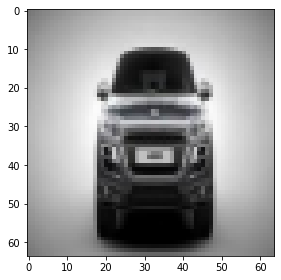

In [ ]:
print(all_labells[40])
imshow(all_images[40])

## Import Test Data

In [ ]:
all_test_images=[]
all_test_labells=[]

for test_img_path in glob.glob("your drive/v_data/test/*/*"):
  img_test_resize = resize(imread(test_img_path),(64,64),anti_aliasing=True)
  all_test_images.append(img_test_resize)
  all_test_labells.append(test_img_path.split('/')[-2])

cars


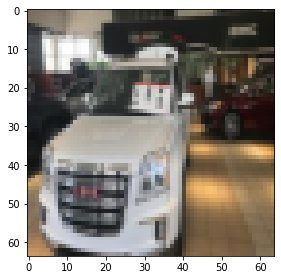

In [ ]:
print(all_test_labells[40])
imshow(all_test_images[40])

# Preprocessing

In [ ]:
all_images = np.array(all_images)

In [ ]:
all_labells = np.array(all_labells)

In [ ]:
all_test_images = np.array(all_test_images)

In [ ]:
all_test_labells = np.array(all_test_labells)

In [ ]:
np.unique(all_labells, return_counts=True)

(array(['cars', 'planes'], dtype='<U6'), array([200, 200]))

## Mapping

In [ ]:
mapping_ids={'cars':0, 'planes':1}

mapping_ids['planes']

1

In [ ]:
mapped_ytrain=[mapping_ids[label] for label in all_labells]
mapped_yvalid=[mapping_ids[label] for label in all_test_labells]

In [ ]:
np.unique(mapped_ytrain, return_counts=True)

(array([0, 1]), array([200, 200]))

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_k=to_categorical(mapped_ytrain, num_classes=5)
y_valid_k=to_categorical(mapped_yvalid, num_classes=5)

# Model

In [ ]:
import tensorflow as tf
from keras.applications import VGG19
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, InputLayer, Dropout, BatchNormalization, Activation, MaxPool2D
from keras.regularizers import L1, L2, L1L2

In [ ]:
# load the model
vgg_model_CLASS = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(64,64,3))

In [ ]:
for layer in vgg_model_CLASS.layers:
    layer.trainable = False

# last layers output
y = vgg_model_CLASS.layers[6].output

# Block 3
y=BatchNormalization()(y)
y = Conv2D(64, (3, 3), activation='relu', padding='same', name='block3_conv1')(y)
y=BatchNormalization()(y)
y = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(y)

#Block 4---> Top layer
y = Flatten(name='flatten')(y)
y = Dense(32, name='block4_dense1', kernel_regularizer='l1')(y) 
y=Dropout(0.1)(y)
y = Dense(5,activation='softmax')(y)

from keras.models import Model
vgg_modified = Model(inputs=vgg_model_CLASS.input, outputs=y)

In [ ]:
print(vgg_modified.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

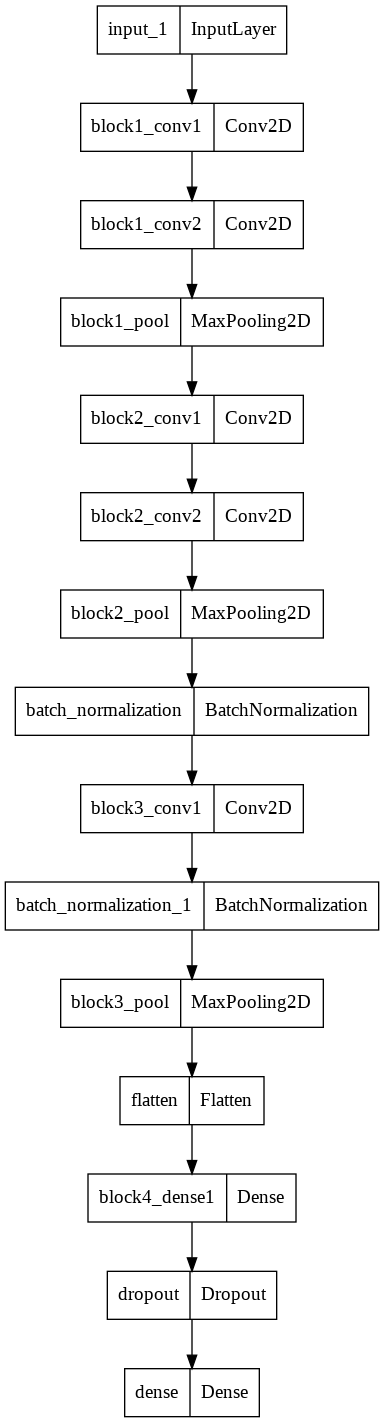

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(vgg_modified, to_file='vgg.png')

In [ ]:
# reset_graph(seed=9)

vgg_modified.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model_training = vgg_modified.fit(all_images, y_train_k, batch_size=16, epochs=100, verbose=1, validation_data=(all_test_images, y_valid_k), shuffle=True)

Epoch 1/100
25/25 [==============================] - 11s 392ms/step - loss: 23.7592 - accuracy: 0.7625 - val_loss: 20.0638 - val_accuracy: 0.8800
Epoch 2/100
25/25 [==============================] - 9s 379ms/step - loss: 16.4533 - accuracy: 0.9300 - val_loss: 13.7524 - val_accuracy: 0.8500
Epoch 3/100
25/25 [==============================] - 9s 382ms/step - loss: 10.8383 - accuracy: 0.9675 - val_loss: 9.1140 - val_accuracy: 0.8600
Epoch 4/100
25/25 [==============================] - 9s 381ms/step - loss: 6.7350 - accuracy: 0.9950 - val_loss: 5.4652 - val_accuracy: 0.8900
Epoch 5/100
25/25 [==============================] - 13s 524ms/step - loss: 3.9856 - accuracy: 1.0000 - val_loss: 3.2339 - val_accuracy: 0.9000
Epoch 6/100
25/25 [==============================] - 13s 496ms/step - loss: 2.3122 - accuracy: 1.0000 - val_loss: 1.9921 - val_accuracy: 0.8900
Epoch 7/100
25/25 [==============================] - 10s 393ms/step - loss: 1.3920 - accuracy: 0.9925 - val_loss: 1.2515 - val_accurac

**History Visualization**

In [ ]:
# list all data in history
print(model_training.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


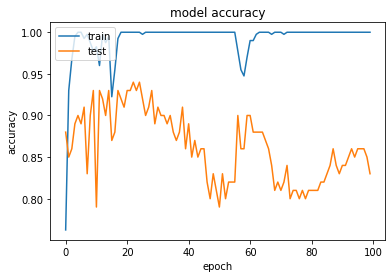

In [ ]:
# summarize history for accuracy
plt.plot(model_training.history['accuracy'])
plt.plot(model_training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

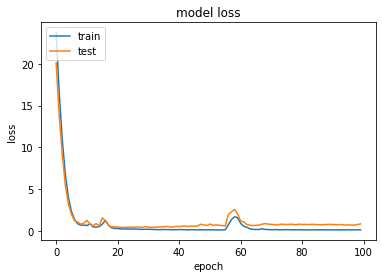

In [ ]:
# summarize history for loss
plt.plot(model_training.history['loss'])
plt.plot(model_training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
4#training
train_pred = vgg_modified.predict(all_images).argmax(axis=-1)
#testing
test_pred = vgg_modified.predict(all_test_images).argmax(axis=-1)

4/4 [==============================] - 2s 359ms/step


#Evaluation Metrics

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
np.array(mapped_ytrain).shape

(400,)

In [ ]:
print("Classification Report of Validation data:\n\n",classification_report(np.array(mapped_ytrain),train_pred))

Classification Report of Validation data:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



In [ ]:
print("Classification Report of testing data:\n\n",classification_report(np.array(mapped_yvalid),test_pred))

Classification Report of testing data:

               precision    recall  f1-score   support

           0       0.95      0.70      0.80        50
           1       0.76      0.96      0.85        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



# Save Model

In [ ]:
vgg_modified.save('/content/drive/MyDrive')